# Prediction Model to Decide Who will Win Between Two World Cup Nations - the Final 16


In [3]:
import pandas as pd
import os

#os.chdir('/Users/pierlim/PycharmProjects/fifa18_final16')
os.chdir('/home/pier/Machine_Learning/fifa18_final16')
df_results = pd.read_csv('data/results.csv')
df_results = df_results[df_results['date'] > '2015-1-1']
df_results.head()
# df_new = df_results[(df_results['home_team'].str.contains("Germany")) | (df_results['away_team'].str.contains("Germany"))]
# df_new

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
126,3/2/00,Scotland,Wales,5,2,British Championship,Aberdeen,Scotland,False
127,24/2/00,Wales,Northern Ireland,2,0,British Championship,Llandudno,Wales,False
128,3/3/00,Northern Ireland,Scotland,0,3,British Championship,Belfast,Ireland,False
130,26/3/00,Wales,England,1,1,British Championship,Cardiff,Wales,False
131,7/4/00,Scotland,England,4,1,British Championship,Glasgow,Scotland,False


In [4]:
#os.chdir('/Users/pierlim/PycharmProjects/fifa18_final16')
os.chdir('/home/pier/Machine_Learning/fifa18_final16')
df_rankings = pd.read_csv('data/fifa_ranking.csv')
df_rankings = df_rankings[df_rankings['rank_date'].str.contains('2018')]
df_rankings =df_rankings.groupby('country_full')['rank', 'cur_year_avg_weighted'].mean()
df_rankings
# df_test = pd.DataFrame(df_test)
# df_test.reset_index()
df_rankings['country_full'] = df_rankings.index
# df_test[df_test['country_full'].str.contains('Germany')]
# df_test


# Join into the main dataset and cleaning

In [5]:
df_combined = df_results.set_index('home_team').join(df_rankings.set_index('country_full'))
df_combined.rename(columns={'rank' : 'home_rank', 'cur_year_avg_weighted' : 'home_weighted_points'}, inplace=True)
df_combined['home_team'] = df_combined.index
df_combined = df_combined.set_index('away_team').join(df_rankings.set_index('country_full'))
df_combined.rename(columns={'rank' : 'away_rank', 'cur_year_avg_weighted' : 'away_weighted_points'}, inplace=True)
df_combined['away_team'] = df_combined.index

Drop scores, and only use win/lose as the predictor.
Remove friendly and drawn matches as we are only interested in win/lose situations now. 

In [6]:
df_combined = df_combined.dropna()
df_combined = df_combined[~df_combined['tournament'].str.contains('Friendly')]
df_combined = df_combined[~(df_combined['home_score']==df_combined['away_score'])]
df_combined.head()


,date,home_score,away_score,tournament,city,country,neutral,home_rank,home_weighted_points,home_team,away_rank,away_weighted_points,away_team
Afghanistan,5/3/79,3,2,AFC Asian Cup qualification,Dhaka,Bangladesh,False,196.500000,0.000,Bangladesh,145.166667,104.065,Afghanistan
Afghanistan,23/3/11,0,3,AFC Challenge Cup qualification,Gurgaon,India,True,185.833333,0.000,Bhutan,145.166667,104.065,Afghanistan
Afghanistan,7/12/11,1,8,SAFF Cup,New Delhi,India,True,185.833333,0.000,Bhutan,145.166667,104.065,Afghanistan
Afghanistan,26/12/15,0,3,SAFF Cup,Thiruvananthapuram,India,True,185.833333,0.000,Bhutan,145.166667,104.065,Afghanistan
Afghanistan,30/7/08,1,0,AFC Challenge Cup,Hyderabad,India,False,99.000000,202.945,India,145.166667,104.065,Afghanistan


Removal of the non-world cup matches seems to aid prediction

In [7]:
df_combined = df_combined[df_combined['tournament'].str.contains('World')]

# Feature generation

In [8]:
# Taking home team to be the one we are interested in 
df_combined['won'] = (df_combined['home_score'] - df_combined['away_score']) >= 1
df_combined.drop(['date', 'city', 'country','home_score','away_score'], axis=1, inplace=True)

In [9]:
df_combined['rank_diff'] = df_combined['home_rank'] - df_combined['away_rank']

In [10]:
df_combined['point_diff'] = df_combined['home_weighted_points'] - df_combined['away_weighted_points']
df_combined.head()

,tournament,neutral,home_rank,home_weighted_points,home_team,away_rank,away_weighted_points,away_team,won,rank_diff,point_diff
Afghanistan,FIFA World Cup qualification,False,57.833333,220.966667,Japan,145.166667,104.065000,Afghanistan,True,-87.333333,116.901667
Afghanistan,FIFA World Cup qualification,False,171.666667,31.260000,Singapore,145.166667,104.065000,Afghanistan,True,26.500000,-72.805000
Afghanistan,FIFA World Cup qualification,False,75.000000,232.328333,Syria,145.166667,104.065000,Afghanistan,True,-70.166667,128.263333
Albania,FIFA World Cup qualification,False,94.666667,166.668333,Armenia,57.833333,243.603333,Albania,True,36.833333,-76.935000
Albania,FIFA World Cup qualification,False,12.000000,754.780000,Denmark,57.833333,243.603333,Albania,True,-45.833333,511.176667


In [11]:
df_combined.dtypes



tournament               object
neutral                    bool
home_rank               float64
home_weighted_points    float64
home_team                object
away_rank               float64
away_weighted_points    float64
away_team                object
won                        bool
rank_diff               float64
point_diff              float64
dtype: object

In [12]:
df_combined['won'] = df_combined['won'].astype(int)

# Data Balancing

In [13]:
from sklearn.utils import resample

df = df_combined
# Separate majority and minority classes
df_majority = df[df.won==1]
df_minority = df[df.won==0]
print(df_majority.shape)
print(df_minority.shape)
print(df_majority.shape[0])


(1875, 11)
(1006, 11)
1875


In [14]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.won.value_counts()
df_combined = df_upsampled
df_combined.to_csv('combined.csv')

# Model Building

In [15]:
y = df_combined['won']
X = df_combined.drop(['won'], axis=1)


# Preprocessing one hot
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X_cat = X.select_dtypes(include=[object, bool])
le = LabelEncoder()
X_cat_labelled = X_cat.apply(le.fit_transform)
X_cat_labelled.head()
X['home_team_orig'] = X['home_team']
X['away_team_orig'] = X['away_team']
X_tosee = pd.concat([X, X_cat_labelled], axis=1)
X_tosee[X_tosee['home_team_orig'].str.contains('Brazil')]


,tournament,neutral,home_rank,home_weighted_points,home_team,away_rank,away_weighted_points,away_team,rank_diff,point_diff,home_team_orig,away_team_orig,tournament,neutral,home_team,away_team
Algeria,FIFA World Cup,True,2.0,638.358333,Brazil,61.500000,212.300000,Algeria,-59.500000,426.058333,Brazil,Algeria,0,1,26,2
Argentina,FIFA World Cup qualification,False,2.0,638.358333,Brazil,4.500000,462.201667,Argentina,-2.500000,176.156667,Brazil,Argentina,1,0,26,8
Bolivia,FIFA World Cup qualification,False,2.0,638.358333,Brazil,52.666667,406.978333,Bolivia,-50.666667,231.380000,Brazil,Bolivia,1,0,26,24
Bolivia,FIFA World Cup qualification,False,2.0,638.358333,Brazil,52.666667,406.978333,Bolivia,-50.666667,231.380000,Brazil,Bolivia,1,0,26,24
Bolivia,FIFA World Cup qualification,False,2.0,638.358333,Brazil,52.666667,406.978333,Bolivia,-50.666667,231.380000,Brazil,Bolivia,1,0,26,24
Bolivia,FIFA World Cup qualification,False,2.0,638.358333,Brazil,52.666667,406.978333,Bolivia,-50.666667,231.380000,Brazil,Bolivia,1,0,26,24
Bolivia,FIFA World Cup qualification,False,2.0,638.358333,Brazil,52.666667,406.978333,Bolivia,-50.666667,231.380000,Brazil,Bolivia,1,0,26,24
Cameroon,FIFA World Cup,True,2.0,638.358333,Brazil,49.500000,256.278333,Cameroon,-47.500000,382.080000,Brazil,Cameroon,0,1,26,31
Cameroon,FIFA World Cup,False,2.0,638.358333,Brazil,49.500000,256.278333,Cameroon,-47.500000,382.080000,Brazil,Cameroon,0,0,26,31
Chile,FIFA World Cup qualification,False,2.0,638.358333,Brazil,9.500000,442.046667,Chile,-7.500000,196.311667,Brazil,Chile,1,0,26,36


In [16]:
X = pd.concat([X,pd.get_dummies(X_cat_labelled['home_team'], prefix='home_team')],axis=1)
X = pd.concat([X,pd.get_dummies(X_cat_labelled['away_team'], prefix='away_team')],axis=1)
X.to_csv('home_away_reference_new.csv')
X = X.drop(['tournament', 'neutral','home_team', 'away_team', 'home_team_orig', 'away_team_orig'], axis=1)
# X = pd.concat([X, X_cat_labelled], axis=1)
y = le.fit_transform(y)
# X.head()

# # # X.hist()
# # # plt.show()
# # # pd.DataFrame(y).hist()
# # # plt.show()

In [17]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
#X = scaler.fit_transform(X)
X.head()
#X.shape

,home_rank,home_weighted_points,away_rank,away_weighted_points,rank_diff,point_diff,home_team_0,home_team_1,home_team_2,home_team_3,...,away_team_181,away_team_182,away_team_183,away_team_184,away_team_185,away_team_186,away_team_187,away_team_188,away_team_189,away_team_190
Afghanistan,57.833333,220.966667,145.166667,104.065000,-87.333333,116.901667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Afghanistan,171.666667,31.260000,145.166667,104.065000,26.500000,-72.805000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Afghanistan,75.000000,232.328333,145.166667,104.065000,-70.166667,128.263333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Albania,94.666667,166.668333,57.833333,243.603333,36.833333,-76.935000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Albania,12.000000,754.780000,57.833333,243.603333,-45.833333,511.176667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(X) 
X.loc[:,:] = scaled_values

In [19]:
X.head()

,home_rank,home_weighted_points,away_rank,away_weighted_points,rank_diff,point_diff,home_team_0,home_team_1,home_team_2,home_team_3,...,away_team_181,away_team_182,away_team_183,away_team_184,away_team_185,away_team_186,away_team_187,away_team_188,away_team_189,away_team_190
Afghanistan,0.276786,0.268575,0.702110,0.126486,0.281848,0.569346,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Afghanistan,0.831169,0.037995,0.702110,0.126486,0.566195,0.448929,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Afghanistan,0.360390,0.282385,0.702110,0.126486,0.324729,0.576558,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Albania,0.456169,0.202578,0.276786,0.296089,0.592007,0.446307,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Albania,0.053571,0.917402,0.276786,0.296089,0.385512,0.819614,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Correlation Matrix

In [20]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df_combined.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


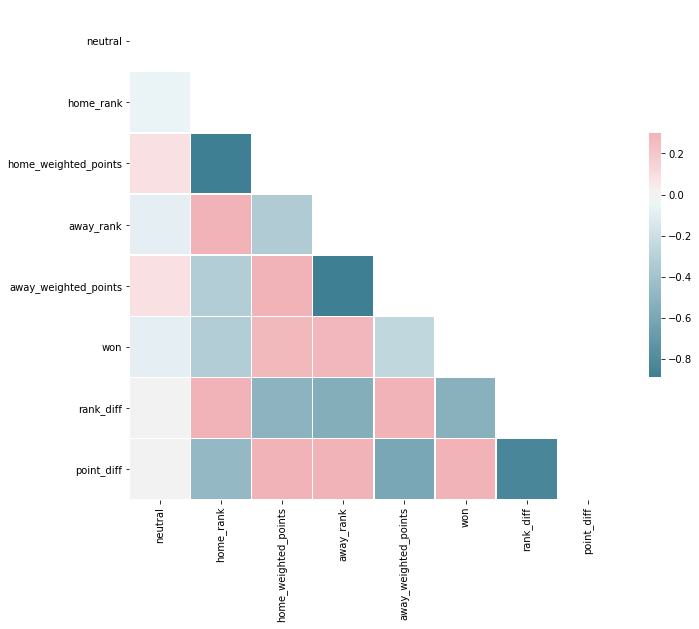

In [21]:
plt.show()

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,home_rank,home_weighted_points,away_rank,away_weighted_points,rank_diff,point_diff,home_team_0,home_team_1,home_team_2,home_team_3,...,away_team_181,away_team_182,away_team_183,away_team_184,away_team_185,away_team_186,away_team_187,away_team_188,away_team_189,away_team_190
Hungary,0.094156,0.630996,0.241071,0.234741,0.424646,0.702081,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chile,0.146916,0.512716,0.041396,0.537288,0.554122,0.482309,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ecuador,0.065747,0.446234,0.309253,0.071408,0.375104,0.690890,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Portugal,0.435065,0.265595,0.012175,0.861726,0.716903,0.183821,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angola,0.520292,0.222785,0.674513,0.140969,0.420899,0.537870,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Do logistic regression with cross validation first

In [24]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


# Logistic Regression
logreg = linear_model.LogisticRegression(C=1, penalty='l2')
features = PolynomialFeatures(degree=2)
lr_model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
lr_model = lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(max_depth=3, random_state=0, n_estimators=1000)
rf_model.fit(X_train, y_train)

# Adaboost
ab_model = AdaBoostClassifier(n_estimators=1000,
                         learning_rate=1,
                         random_state=0)
ab_model.fit(X_train, y_train)

# kNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train) 

# Neural Networks
nn_model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100,100,50), random_state=1)
nn_model.fit(X_train, y_train) 


scores = cross_val_score(lr_model, X_train, y_train, cv=5)
print("Logistic Regression")
print(scores)

scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print("Random Forests")
print(scores)

scores = cross_val_score(ab_model, X_train, y_train, cv=5)
print("Adaboost")
print(scores)

scores = cross_val_score(knn_model, X_train, y_train, cv=5)
print("kNN")
print(scores)

scores = cross_val_score(nn_model, X_train, y_train, cv=5)
print("Neural Networks")
print(scores)



Logistic Regression
[ 0.83666667  0.82833333  0.84        0.82666667  0.82666667]
Random Forests
[ 0.73        0.74166667  0.71333333  0.73666667  0.74      ]
Adaboost
[ 0.825       0.8         0.80666667  0.80166667  0.81      ]
kNN
[ 0.79333333  0.75666667  0.77166667  0.76166667  0.77333333]
Neural Networks
[ 0.83333333  0.81833333  0.84833333  0.82666667  0.82      ]


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

## Adaboost - Validation with 20% Test Result


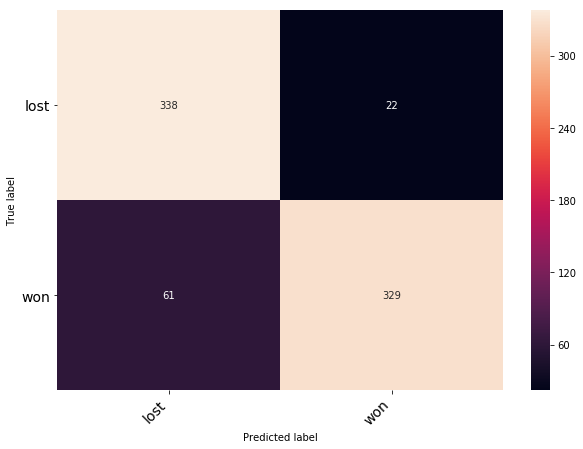

In [29]:
from sklearn import metrics

ab_pred = nn_model.predict(X_test)
cm = metrics.confusion_matrix(y_test, ab_pred )
print_confusion_matrix(cm, ['lost', 'won'])

In [30]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score

print('area under curve: {}'.format(roc_auc_score(y_test, ab_pred)))
print('accuracy: {}'.format(accuracy_score(y_test, ab_pred)))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, ab_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

area under curve: 0.8912393162393163
accuracy: 0.8893333333333333
precision: [ 0.84711779  0.93732194]
recall: [ 0.93888889  0.84358974]
fscore: [ 0.89064559  0.8879892 ]
support: [360 390]


## kNN - Validation with 20% Test Result

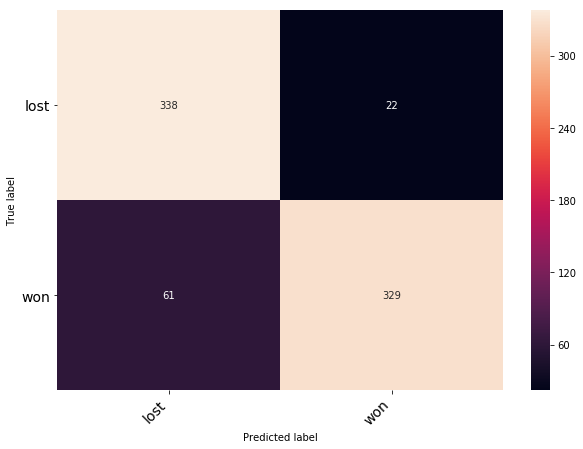

In [31]:
from sklearn import metrics

knn_pred = nn_model.predict(X_test)
cm = metrics.confusion_matrix(y_test, knn_pred )
print_confusion_matrix(cm, ['lost', 'won'])

In [32]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score

print('area under curve: {}'.format(roc_auc_score(y_test, knn_pred)))
print('accuracy: {}'.format(accuracy_score(y_test, knn_pred)))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, knn_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

area under curve: 0.8912393162393163
accuracy: 0.8893333333333333
precision: [ 0.84711779  0.93732194]
recall: [ 0.93888889  0.84358974]
fscore: [ 0.89064559  0.8879892 ]
support: [360 390]


## Neural Networks - Validation with 20% Test Results

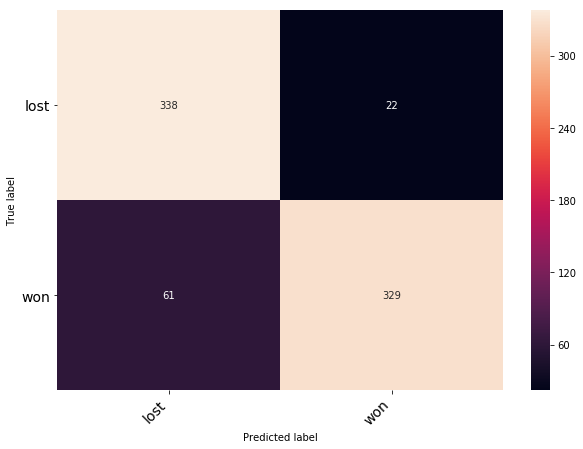

In [33]:
from sklearn import metrics

nn_pred = nn_model.predict(X_test)
cm = metrics.confusion_matrix(y_test, nn_pred )
print_confusion_matrix(cm, ['lost', 'won'])

In [34]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score

print('area under curve: {}'.format(roc_auc_score(y_test, nn_pred)))
print('accuracy: {}'.format(accuracy_score(y_test, knn_pred)))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, nn_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

area under curve: 0.8912393162393163
accuracy: 0.8893333333333333
precision: [ 0.84711779  0.93732194]
recall: [ 0.93888889  0.84358974]
fscore: [ 0.89064559  0.8879892 ]
support: [360 390]


# Simulation : Final 16 Results

Adaboost, Neural Networks and kNN are evenly matched at ~88% , use a ensemble voting scheme.

In [35]:
df_final16 = pd.read_csv('data/X_final16.csv') # Pre-created data for the 8 matches

# use previous scaler
scaled_values = scaler.fit_transform(df_final16) 
df_final16.loc[:,:] = scaled_values

In [36]:
df_final16


,Unnamed: 0,home_rank,home_weighted_points,away_rank,away_weighted_points,rank_diff,point_diff,home_team_0,home_team_1,home_team_2,...,away_team_181,away_team_182,away_team_183,away_team_184,away_team_185,away_team_186,away_team_187,away_team_188,away_team_189,away_team_190
0,0.000000,0.315789,0.553335,0.016349,0.460546,0.835240,0.504723,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.142857,0.894737,0.101503,0.000000,0.915542,1.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.285714,0.280702,0.866528,1.000000,0.000000,0.000000,0.961155,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.428571,0.780702,0.395749,0.138965,1.000000,0.853547,0.049133,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.571429,0.000000,0.972051,0.204360,0.519311,0.594966,0.619735,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.714286,0.105263,1.000000,0.888283,0.015758,0.048055,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.857143,1.000000,0.758718,0.057221,0.739180,0.979405,0.377727,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.000000,0.657895,0.000000,0.177112,0.492751,0.789474,0.272074,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
df_final16 = df_final16.drop(df_final16.columns[0], axis=1) # drop NA column

In [68]:
nn_answer = nn_model.predict(df_final16)
nn_prob_est = nn_model.predict_proba(df_final16)
print("         Predict 0      :      Predict 1")
nn_prob_est

         Predict 0      :      Predict 1


array([[  9.59580299e-01,   4.04197010e-02],
       [  5.83053279e-01,   4.16946721e-01],
       [  8.54256196e-06,   9.99991457e-01],
       [  5.77457658e-01,   4.22542342e-01],
       [  8.63258193e-04,   9.99136742e-01],
       [  4.61962779e-05,   9.99953804e-01],
       [  9.86607986e-01,   1.33920141e-02],
       [  5.98654391e-01,   4.01345609e-01]])

In [71]:
def print_result(nn_answer, nn_prob_est):
    print('France vs Argentina : {} Probability {}'.format(nn_answer[0], nn_prob_est[0][0] if nn_answer[0] == 0 else nn_prob_est[0][1]))
    print('Uruguay vs Portugal : {} Probability {}'.format(nn_answer[1], nn_prob_est[1][0] if nn_answer[1] == 0 else nn_prob_est[1][1]))
    print('Spain vs Russia : {} Probability {}'.format(nn_answer[2], nn_prob_est[2][0] if nn_answer[2] == 0 else nn_prob_est[2][1]))
    print('Croatia vs Denmark : {} Probability {}'.format(nn_answer[3], nn_prob_est[3][0] if nn_answer[3] == 0 else nn_prob_est[3][1]))
    print('Brazil vs Mexico : {} Probability {}'.format(nn_answer[4], nn_prob_est[4][0] if nn_answer[4] == 0 else nn_prob_est[4][1]))
    print('Belgium vs Japan : {} Probability {}'.format(nn_answer[5], nn_prob_est[5][0] if nn_answer[5] == 0 else nn_prob_est[5][1]))
    print('Sweden vs Switzerland : {} Probability {}'.format(nn_answer[6], nn_prob_est[6][0] if nn_answer[6] == 0 else nn_prob_est[6][1]))
    print('Colombia vs England : {} Probability {}'.format(nn_answer[7], nn_prob_est[7][0] if nn_answer[7] == 0 else nn_prob_est[7][1]))

In [72]:
print("Neural Networks Quarters Prediction")
print('1 means a win for the 1st country.')
print_result(nn_answer, nn_prob_est)
# print('France vs Argentina : {} Probability {}'.format(nn_answer[0], nn_prob_est[0][0] if nn_answer[0] == 0 else nn_prob_est[0][1]))
# print('Uruguay vs Portugal : {} Probability {}'.format(nn_answer[1], nn_prob_est[1][0] if nn_answer[1] == 0 else nn_prob_est[1][1]))
# print('Spain vs Russia : {} Probability {}'.format(nn_answer[2], nn_prob_est[2][0] if nn_answer[2] == 0 else nn_prob_est[2][1]))
# print('Croatia vs Denmark : {} Probability {}'.format(nn_answer[3], nn_prob_est[3][0] if nn_answer[3] == 0 else nn_prob_est[3][1]))
# print('Brazil vs Mexico : {} Probability {}'.format(nn_answer[4], nn_prob_est[4][0] if nn_answer[4] == 0 else nn_prob_est[4][1]))
# print('Belgium vs Japan : {} Probability {}'.format(nn_answer[5], nn_prob_est[5][0] if nn_answer[5] == 0 else nn_prob_est[5][1]))
# print('Sweden vs Switzerland : {} Probability {}'.format(nn_answer[6], nn_prob_est[6][0] if nn_answer[6] == 0 else nn_prob_est[6][1]))
# print('Colombia vs England : {} Probability {}'.format(nn_answer[7], nn_prob_est[7][0] if nn_answer[7] == 0 else nn_prob_est[7][1]))

Neural Networks Quarters Prediction
1 means a win for the 1st country.
France vs Argentina : 0 Probability 0.9595802989802886
Uruguay vs Portugal : 0 Probability 0.5830532787582983
Spain vs Russia : 1 Probability 0.9999914574380361
Croatia vs Denmark : 0 Probability 0.5774576583407938
Brazil vs Mexico : 1 Probability 0.999136741806851
Belgium vs Japan : 1 Probability 0.9999538037220946
Sweden vs Switzerland : 0 Probability 0.9866079859027916
Colombia vs England : 0 Probability 0.5986543914851383


In [55]:
knn_answer = knn_model.predict(df_final16)
knn_model_est = knn_model.predict_proba(df_final16)
print("         Predict 0      :      Predict 1")
knn_model_est

         Predict 0            Predict 1


array([[ 0.8,  0.2],
       [ 0.6,  0.4],
       [ 0. ,  1. ],
       [ 0.2,  0.8],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0.6,  0.4],
       [ 0.6,  0.4]])

In [73]:
print("kNN Quarters Prediction")
print('1 means a win for the 1st country.')
print_result(knn_answer, knn_model_est)
# print('France vs Argentina : {}'.format(knn_answer[0]))
# print('Uruguay vs Portugal : {}'.format(knn_answer[1]))
# print('Spain vs Russia : {}'.format(knn_answer[2]))
# print('Croatia vs Denmark : {}'.format(knn_answer[3]))
# print('Brazil vs Mexico : {}'.format(knn_answer[4]))
# print('Belgium vs Japan : {}'.format(knn_answer[5]))
# print('Sweden vs Switzerland : {}'.format(knn_answer[6]))
# print('Colombia vs England : {}'.format(knn_answer[7]))

kNN Quarters Prediction
1 means a win for the 1st country.
France vs Argentina : 0 Probability 0.8
Uruguay vs Portugal : 0 Probability 0.6
Spain vs Russia : 1 Probability 1.0
Croatia vs Denmark : 1 Probability 0.8
Brazil vs Mexico : 1 Probability 1.0
Belgium vs Japan : 1 Probability 1.0
Sweden vs Switzerland : 0 Probability 0.6
Colombia vs England : 0 Probability 0.6


In [56]:
ab_answer = ab_model.predict(df_final16)
ab_model_est = ab_model.predict_proba(df_final16)
print("         Predict 0       :     Predict 1")
ab_model_est

         Predict 0       :     Predict 1


array([[ 0.50167157,  0.49832843],
       [ 0.50722756,  0.49277244],
       [ 0.48098378,  0.51901622],
       [ 0.51007971,  0.48992029],
       [ 0.50008757,  0.49991243],
       [ 0.48085464,  0.51914536],
       [ 0.50981361,  0.49018639],
       [ 0.49267357,  0.50732643]])

In [75]:
print("Adaptive Boosting Prediction")
print('1 means a win for the 1st country.')
print_result(ab_answer, ab_model_est)
# print('France vs Argentina : {}'.format(ab_answer[0]))
# print('Uruguay vs Portugal : {}'.format(ab_answer[1]))
# print('Spain vs Russia : {}'.format(ab_answer[2]))
# print('Croatia vs Denmark : {}'.format(ab_answer[3]))
# print('Brazil vs Mexico : {}'.format(ab_answer[4]))
# print('Belgium vs Japan : {}'.format(ab_answer[5]))
# print('Sweden vs Switzerland : {}'.format(ab_answer[6]))
# print('Colombia vs England : {}'.format(ab_answer[7]))

Adaptive Boosting Prediction
1 means a win for the 1st country.
France vs Argentina : 0 Probability 0.5016715724847414
Uruguay vs Portugal : 0 Probability 0.5072275580272426
Spain vs Russia : 1 Probability 0.519016216052486
Croatia vs Denmark : 0 Probability 0.5100797086903618
Brazil vs Mexico : 0 Probability 0.5000875691969225
Belgium vs Japan : 1 Probability 0.5191453576726687
Sweden vs Switzerland : 0 Probability 0.5098136100031829
Colombia vs England : 1 Probability 0.5073264264051887


# Final Ensemble Prediction with Voting

In [79]:
final_prob = (ab_model_est + knn_model_est + nn_prob_est) / 3.0
final_prediction = []

for i in range(8):
    if (ab_answer[i] + nn_answer[i] + knn_answer[i]) > 1:
        final_prediction.append(1)
    else:
        final_prediction.append(0)
        

In [83]:
print("Ensemble Prediction")
print('1 means a win for the 1st country.')
print_result(final_prediction, final_prob)

# print('France vs Argentina : {}'.format(final_prediction[0]))
# print('Uruguay vs Portugal : {}'.format(final_prediction[1]))
# print('Spain vs Russia : {}'.format(final_prediction[2]))
# print('Croatia vs Denmark : {}'.format(final_prediction[3]))
# print('Brazil vs Mexico : {}'.format(final_prediction[4]))
# print('Belgium vs Japan : {}'.format(final_prediction[5]))
# print('Sweden vs Switzerland : {}'.format(final_prediction[6]))
# print('Colombia vs England : {}'.format(final_prediction[7]))

Ensemble Prediction
1 means a win for the 1st country.
France vs Argentina : 0 Probability 0.7537506238216767
Uruguay vs Portugal : 0 Probability 0.5634269455951803
Spain vs Russia : 1 Probability 0.8396692244968408
Croatia vs Denmark : 0 Probability 0.4291791223437185
Brazil vs Mexico : 1 Probability 0.8330163908699761
Belgium vs Japan : 1 Probability 0.8396997204649211
Sweden vs Switzerland : 0 Probability 0.6988071986353249
Colombia vs England : 0 Probability 0.5637759883599832


array([[ 0.75375062,  0.24624938],
       [ 0.56342695,  0.43657305],
       [ 0.16033078,  0.83966922],
       [ 0.42917912,  0.57082088],
       [ 0.16698361,  0.83301639],
       [ 0.16030028,  0.83969972],
       [ 0.6988072 ,  0.3011928 ],
       [ 0.56377599,  0.43622401]])